In [8]:
import urllib.request
import json
import pandas as pd
import datetime
import urllib.parse
import ssl

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
import platform

# 공공데이터 API 키
API_KEY = "자기꺼"


In [9]:
# 서울특별시 내 구/군 코드
SEOUL_DISTRICTS = {
    "강남구": 680, "강동구": 740, "강북구": 305, "강서구": 500, "관악구": 620, "광진구": 215,
    "구로구": 530, "금천구": 545, "노원구": 350, "도봉구": 320, "동대문구": 230, "동작구": 590,
    "마포구": 440, "서대문구": 410, "서초구": 650, "성동구": 200, "성북구": 290, "송파구": 710,
    "양천구": 470, "영등포구": 560, "용산구": 170, "은평구": 380, "종로구": 110, "중구": 140, "중랑구": 260
}
# 최신 SSL/TLS 설정 적용
context = ssl.create_default_context()
context.set_ciphers('DEFAULT@SECLEVEL=1')


In [10]:
# 한글 폰트 설정 (Windows, Mac, Linux 자동 감지)
def set_korean_font():
    system_platform = platform.system()
    if system_platform == "Windows":
        font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows: 맑은 고딕
    elif system_platform == "Darwin":  # MacOS
        font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"
    else:  # Linux
        font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

    font_prop = fm.FontProperties(fname=font_path)

    # Matplotlib 기본 폰트 설정
    plt.rcParams["font.family"] = font_prop.get_name()
    plt.rcParams["axes.unicode_minus"] = False  # 음수 기호 깨짐 방지


# 한글 폰트 설정 적용
set_korean_font()

In [11]:
# 구별 자전거 사고 데이터 시각화
def visualizeData(result_df, guGun_name, searchYearCd):
    plt.figure(figsize=(14, 7))

    # 막대 그래프를 위한 데이터 설정
    categories = ["occrrnc_cnt", "caslt_cnt", "dth_dnv_cnt", "se_dnv_cnt", "sl_dnv_cnt", "wnd_dnv_cnt"]
    x_labels = result_df["sido_sgg_nm"].unique()  # 구 이름

    values = {cat: result_df.groupby("sido_sgg_nm")[cat].sum() for cat in categories}

    x = np.arange(len(x_labels))  # X축 위치 설정
    width = 0.15  # 막대 너비

    # 여러 개의 데이터 세트를 옆으로 배치
    for i, cat in enumerate(categories):
        plt.bar(x + i * width, values[cat], width, label=cat)

    # X축 및 제목 설정
    plt.xlabel("구 이름", fontsize=14)
    plt.ylabel("건수", fontsize=14)
    plt.title(f"{searchYearCd}년 서울특별시 {guGun_name} 자전거 사고 통계", fontsize=16)
    plt.xticks(x + width, x_labels, rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)

    # 그래프 저장
    plt.savefig(f"bicycle_accidents_chart_{searchYearCd}_서울특별시_{guGun_name}.png", dpi=300)
    plt.show()
    print(f"✅ 그래프 저장 완료: bicycle_accidents_chart_{searchYearCd}_서울특별시_{guGun_name}.png")



In [12]:
# 요청을 보내고 데이터를 가져오는 함수
def getRequestUrl(url):
    req = urllib.request.Request(url)
    try:
        response = urllib.request.urlopen(req, context=context)
        if response.getcode() == 200:
            print("[%s] URL 요청 성공" % datetime.datetime.now())
            return response.read().decode("utf-8")
    except Exception as e:
        print("[%s] 오류 발생: %s" % (datetime.datetime.now(), str(e)))
        return None

In [13]:
# API 요청 및 데이터 저장 함수
def fetchAndSaveData(searchYearCd, siDo, guGun, numOfRows=100, pageNo=1):
    base_url = "https://apis.data.go.kr/B552061/frequentzoneBicycle/getRestFrequentzoneBicycle"

    params = {
        "ServiceKey": API_KEY,
        "searchYearCd": searchYearCd,
        "siDo": siDo,
        "guGun": guGun,
        "type": "json",
        "numOfRows": str(numOfRows),
        "pageNo": str(pageNo),
    }

    # URL 인코딩
    query_string = urllib.parse.urlencode(params, doseq=True)
    url = f"{base_url}?{query_string}"

    responseDecode = getRequestUrl(url)

    # 응답이 None이거나 빈 문자열인지 확인
    if responseDecode is None or responseDecode.strip() == "":
        print(f"🚨 [오류] API 응답이 비어 있습니다. 파일을 생성하지 않습니다. (구/군 코드: {guGun})")
        return

    # JSON 파싱 전에 응답이 유효한 JSON인지 확인
    try:
        jsonData = json.loads(responseDecode)
    except json.JSONDecodeError as e:
        print(f"🚨 [오류] JSON 변환 실패. 파일을 생성하지 않습니다. (구/군 코드: {guGun}): {e}")
        print(f"응답 내용: {responseDecode[:200]} ...")  # 응답 일부 출력
        return

    # API 응답에서 "items" 키가 존재하는지 확인
    if "items" not in jsonData or "item" not in jsonData["items"]:
        print(f"🚨 [오류] API 응답에 데이터가 없습니다. 파일을 생성하지 않습니다. (구/군 코드: {guGun})")
        return

    dataList = jsonData["items"]["item"]

    if not dataList:  # 리스트가 비어있다면 저장하지 않음
        print(f"🚨 [오류] 응답 데이터가 없습니다. 파일을 생성하지 않습니다. (구/군 코드: {guGun})")
        return

    jsonResult = []
    result = []

    for item in dataList:
        jsonResult.append(item)
        result.append([
            item.get("afos_fid", ""),
            item.get("afos_id", ""),
            item.get("bjd_cd", ""),
            item.get("spot_cd", ""),
            item.get("sido_sgg_nm", ""),
            item.get("spot_nm", ""),
            item.get("occrrnc_cnt", ""),
            item.get("caslt_cnt", ""),
            item.get("dth_dnv_cnt", ""),
            item.get("se_dnv_cnt", ""),
            item.get("sl_dnv_cnt", ""),
            item.get("wnd_dnv_cnt", ""),
            item.get("lo_crd", ""),
            item.get("la_crd", ""),
        ])

    # 파일 이름 설정
    guGun_name = "전체" if guGun == "9999" else [k for k, v in SEOUL_DISTRICTS.items() if v == int(guGun)][0]
    json_filename = f"bicycle_accidents_{searchYearCd}_서울특별시_{guGun_name}.json"
    csv_filename = f"bicycle_accidents_{searchYearCd}_서울특별시_{guGun_name}.csv"

    # JSON 파일 저장
    with open(json_filename, "w", encoding="utf-8") as outfile:
        json.dump(jsonResult, outfile, indent=4, ensure_ascii=False)
    print(f"✅ JSON 데이터 저장 완료: {json_filename}")

    # CSV 파일 저장
    columns = ["afos_fid", "afos_id", "bjd_cd", "spot_cd", "sido_sgg_nm", "spot_nm",
               "occrrnc_cnt", "caslt_cnt", "dth_dnv_cnt", "se_dnv_cnt", "sl_dnv_cnt", "wnd_dnv_cnt",
               "lo_crd", "la_crd"]
    result_df = pd.DataFrame(result, columns=columns)
    result_df.to_csv(csv_filename, index=False, encoding="utf-8-sig")
    print(f"✅ CSV 데이터 저장 완료: {csv_filename}")

    # 그래프 시각화 실행 (CSV 데이터 활용)
    visualizeData(result_df, guGun_name, searchYearCd)


서울특별시 내 구/군 선택 (9999 입력 시 전체 선택)
강남구: 680 | 강동구: 740 | 강북구: 305 | 강서구: 500 | 관악구: 620 | 광진구: 215 | 구로구: 530 | 금천구: 545 | 노원구: 350 | 도봉구: 320 | 동대문구: 230 | 동작구: 590 | 마포구: 440 | 서대문구: 410 | 서초구: 650 | 성동구: 200 | 성북구: 290 | 송파구: 710 | 양천구: 470 | 영등포구: 560 | 용산구: 170 | 은평구: 380 | 종로구: 110 | 중구: 140 | 중랑구: 260 | [2025-02-19 17:02:51.533023] URL 요청 성공
✅ JSON 데이터 저장 완료: bicycle_accidents_2023_서울특별시_강남구.json
✅ CSV 데이터 저장 완료: bicycle_accidents_2023_서울특별시_강남구.csv


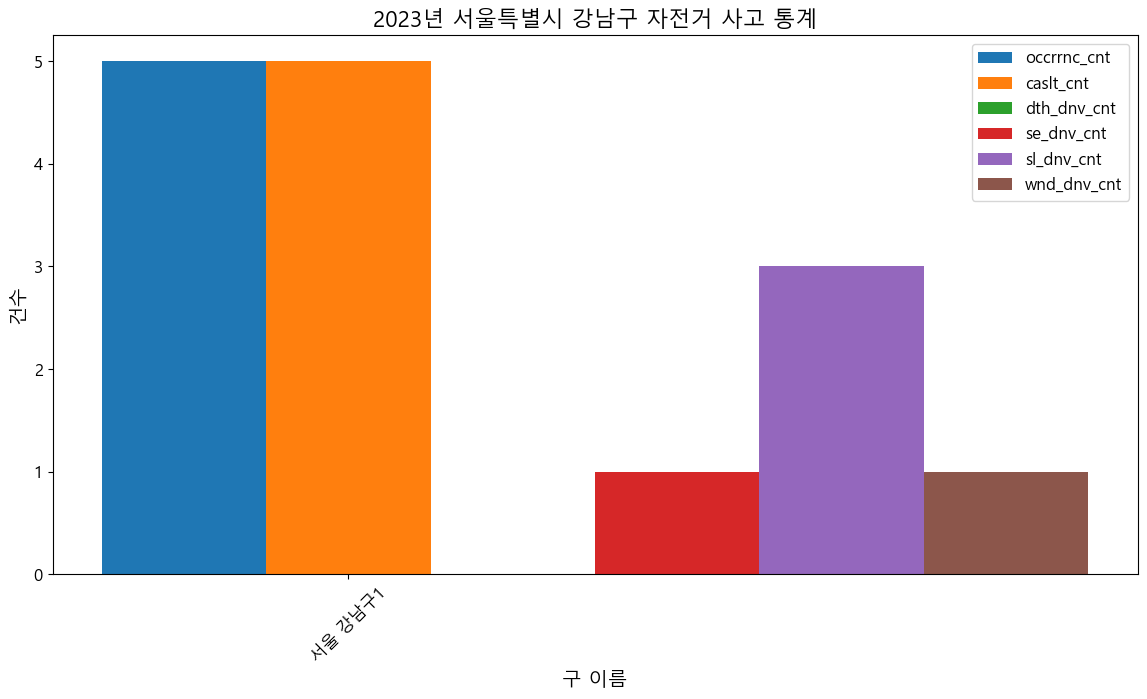

✅ 그래프 저장 완료: bicycle_accidents_chart_2023_서울특별시_강남구.png
[2025-02-19 17:02:52.759852] URL 요청 성공
✅ JSON 데이터 저장 완료: bicycle_accidents_2023_서울특별시_강동구.json
✅ CSV 데이터 저장 완료: bicycle_accidents_2023_서울특별시_강동구.csv


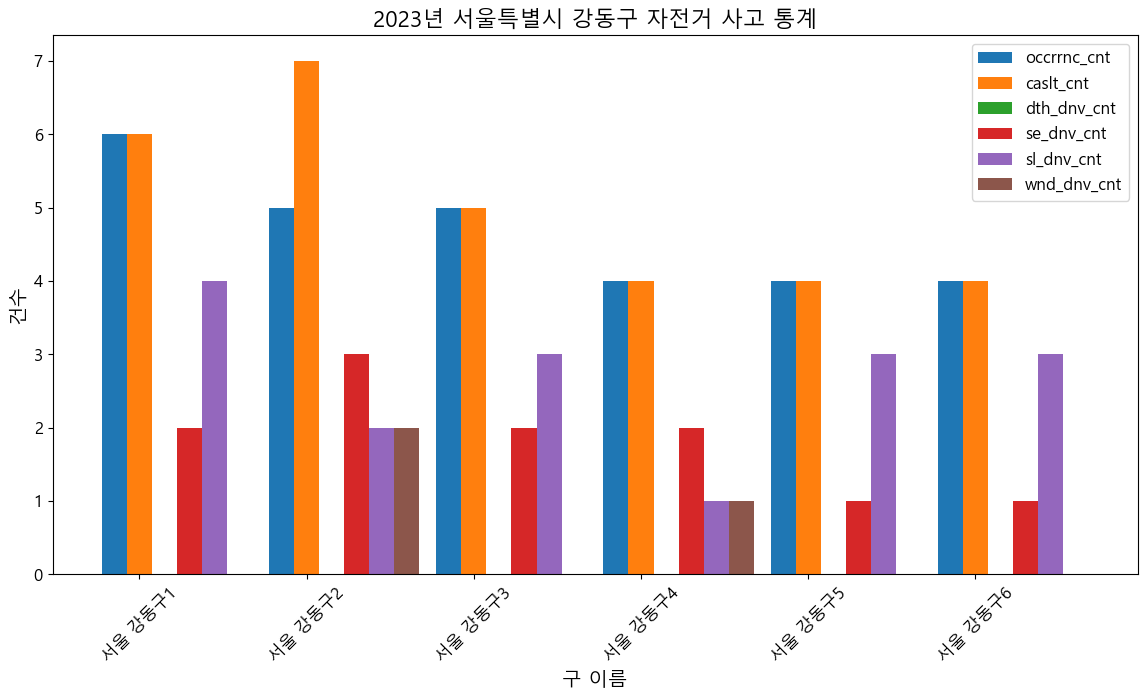

✅ 그래프 저장 완료: bicycle_accidents_chart_2023_서울특별시_강동구.png
[2025-02-19 17:02:53.999166] URL 요청 성공
✅ JSON 데이터 저장 완료: bicycle_accidents_2023_서울특별시_강북구.json
✅ CSV 데이터 저장 완료: bicycle_accidents_2023_서울특별시_강북구.csv


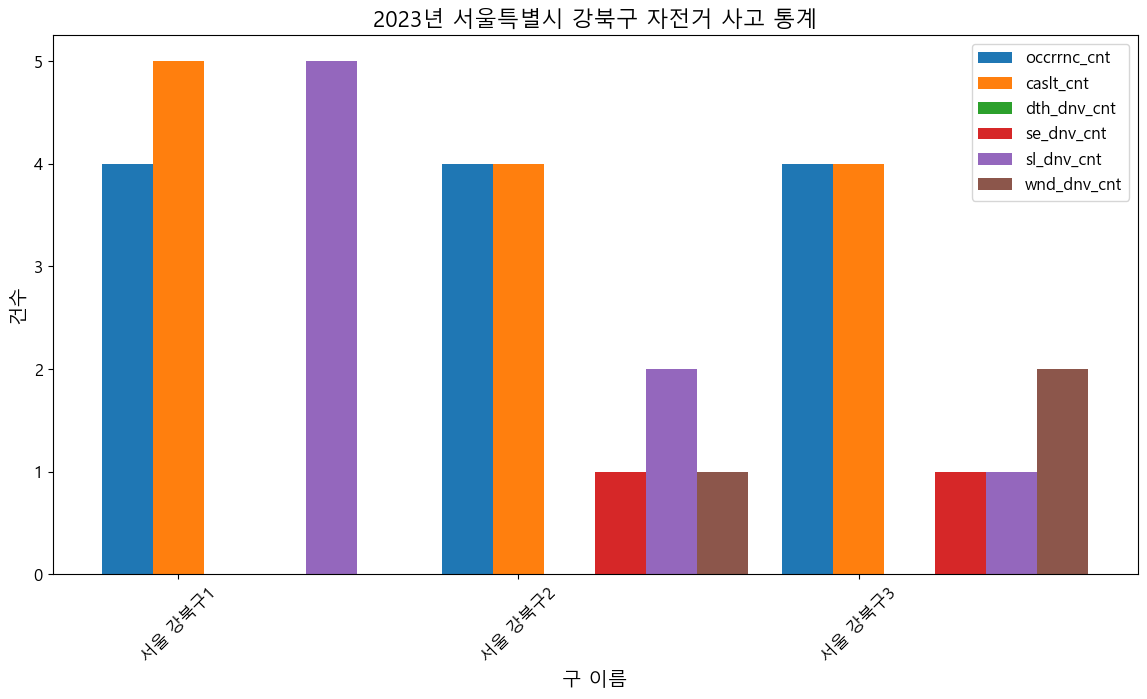

✅ 그래프 저장 완료: bicycle_accidents_chart_2023_서울특별시_강북구.png
[2025-02-19 17:02:54.911413] URL 요청 성공
✅ JSON 데이터 저장 완료: bicycle_accidents_2023_서울특별시_강서구.json
✅ CSV 데이터 저장 완료: bicycle_accidents_2023_서울특별시_강서구.csv


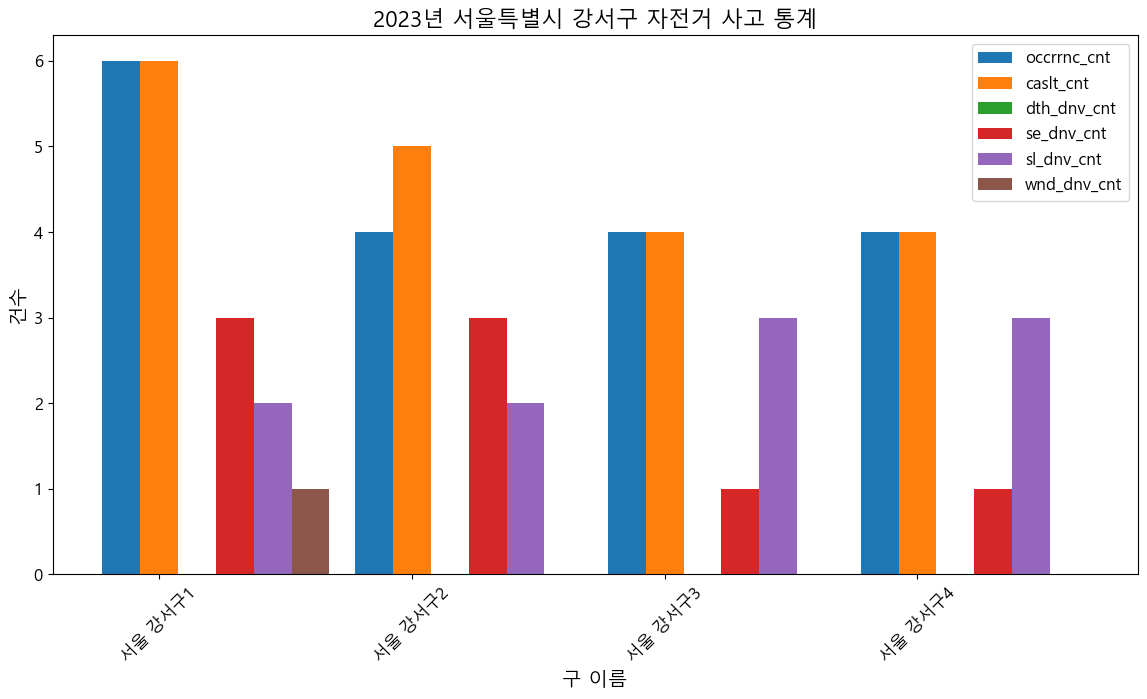

✅ 그래프 저장 완료: bicycle_accidents_chart_2023_서울특별시_강서구.png
[2025-02-19 17:02:55.944652] URL 요청 성공
✅ JSON 데이터 저장 완료: bicycle_accidents_2023_서울특별시_관악구.json
✅ CSV 데이터 저장 완료: bicycle_accidents_2023_서울특별시_관악구.csv


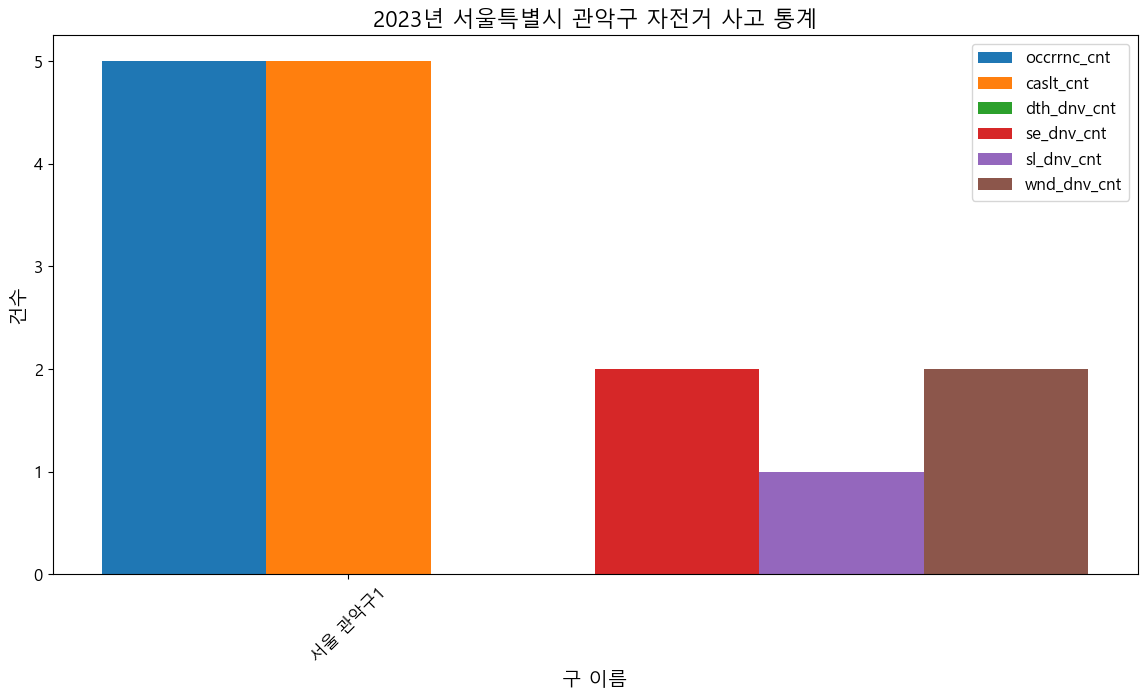

✅ 그래프 저장 완료: bicycle_accidents_chart_2023_서울특별시_관악구.png
[2025-02-19 17:02:56.961046] URL 요청 성공
🚨 [오류] 응답 데이터가 없습니다. 파일을 생성하지 않습니다. (구/군 코드: 215)
[2025-02-19 17:02:57.188413] URL 요청 성공
✅ JSON 데이터 저장 완료: bicycle_accidents_2023_서울특별시_구로구.json
✅ CSV 데이터 저장 완료: bicycle_accidents_2023_서울특별시_구로구.csv


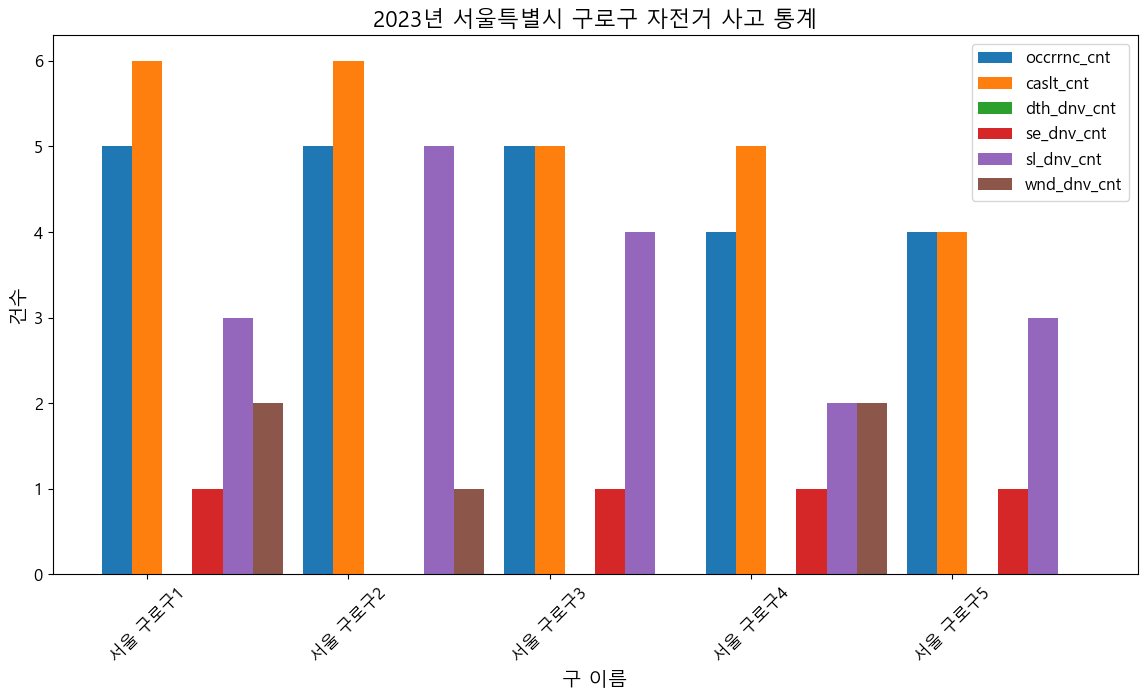

✅ 그래프 저장 완료: bicycle_accidents_chart_2023_서울특별시_구로구.png
[2025-02-19 17:02:58.238230] URL 요청 성공
🚨 [오류] 응답 데이터가 없습니다. 파일을 생성하지 않습니다. (구/군 코드: 545)
[2025-02-19 17:02:58.502411] URL 요청 성공
✅ JSON 데이터 저장 완료: bicycle_accidents_2023_서울특별시_노원구.json
✅ CSV 데이터 저장 완료: bicycle_accidents_2023_서울특별시_노원구.csv


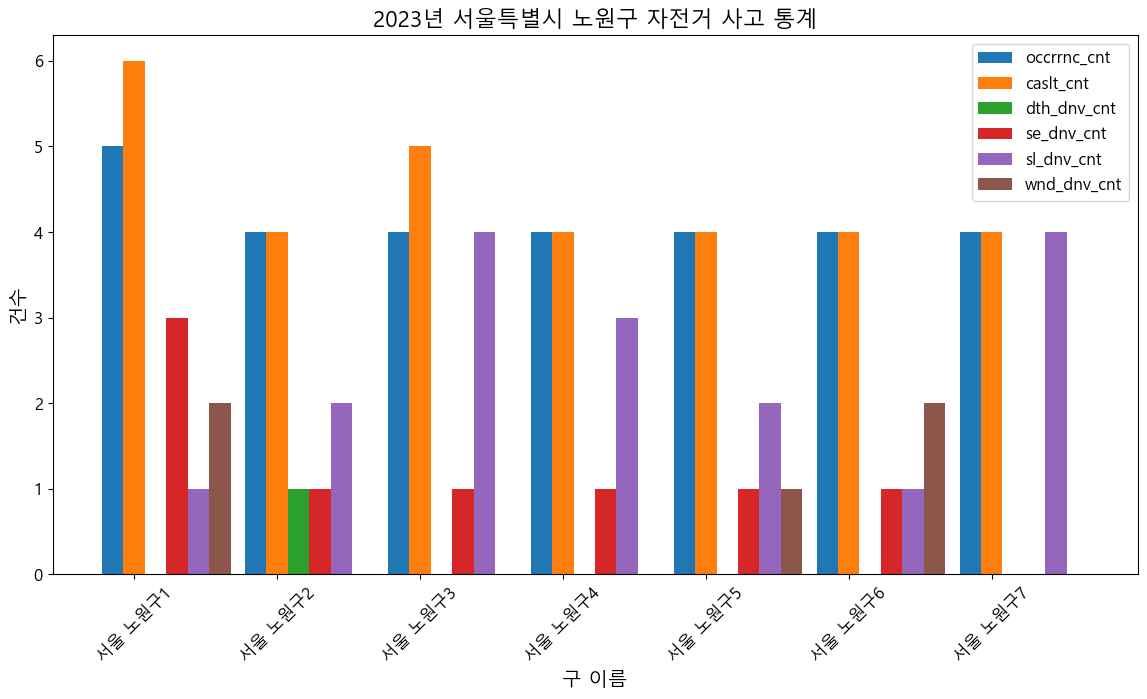

✅ 그래프 저장 완료: bicycle_accidents_chart_2023_서울특별시_노원구.png
[2025-02-19 17:02:59.590545] URL 요청 성공
✅ JSON 데이터 저장 완료: bicycle_accidents_2023_서울특별시_도봉구.json
✅ CSV 데이터 저장 완료: bicycle_accidents_2023_서울특별시_도봉구.csv


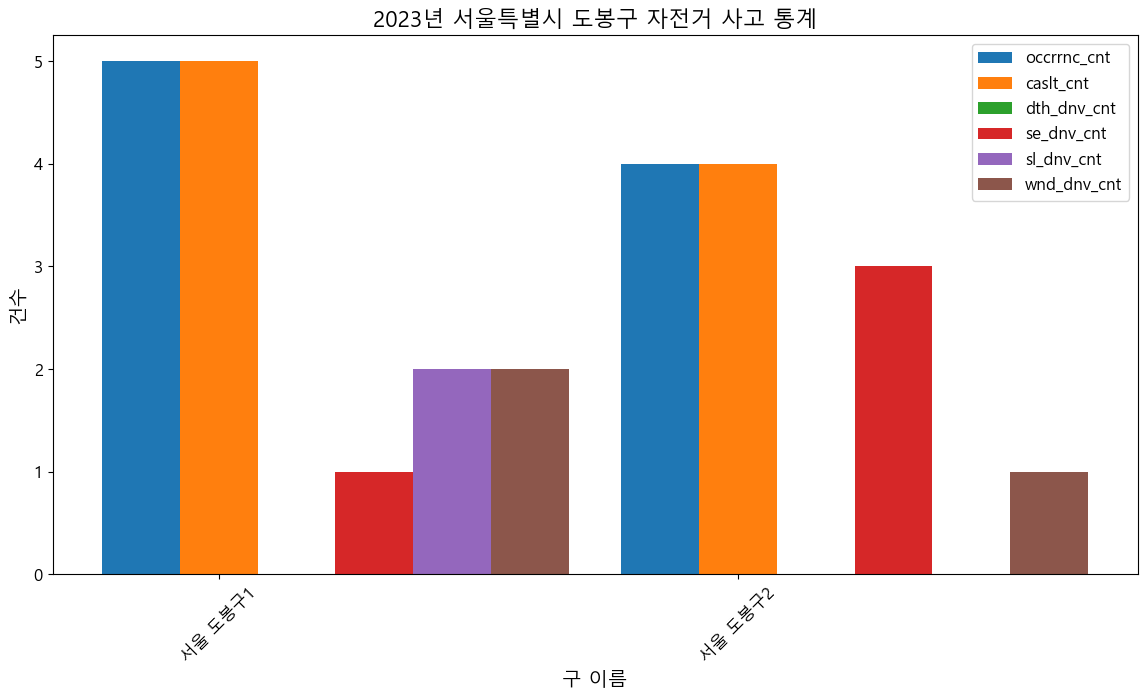

✅ 그래프 저장 완료: bicycle_accidents_chart_2023_서울특별시_도봉구.png
[2025-02-19 17:03:00.417648] URL 요청 성공
✅ JSON 데이터 저장 완료: bicycle_accidents_2023_서울특별시_동대문구.json
✅ CSV 데이터 저장 완료: bicycle_accidents_2023_서울특별시_동대문구.csv


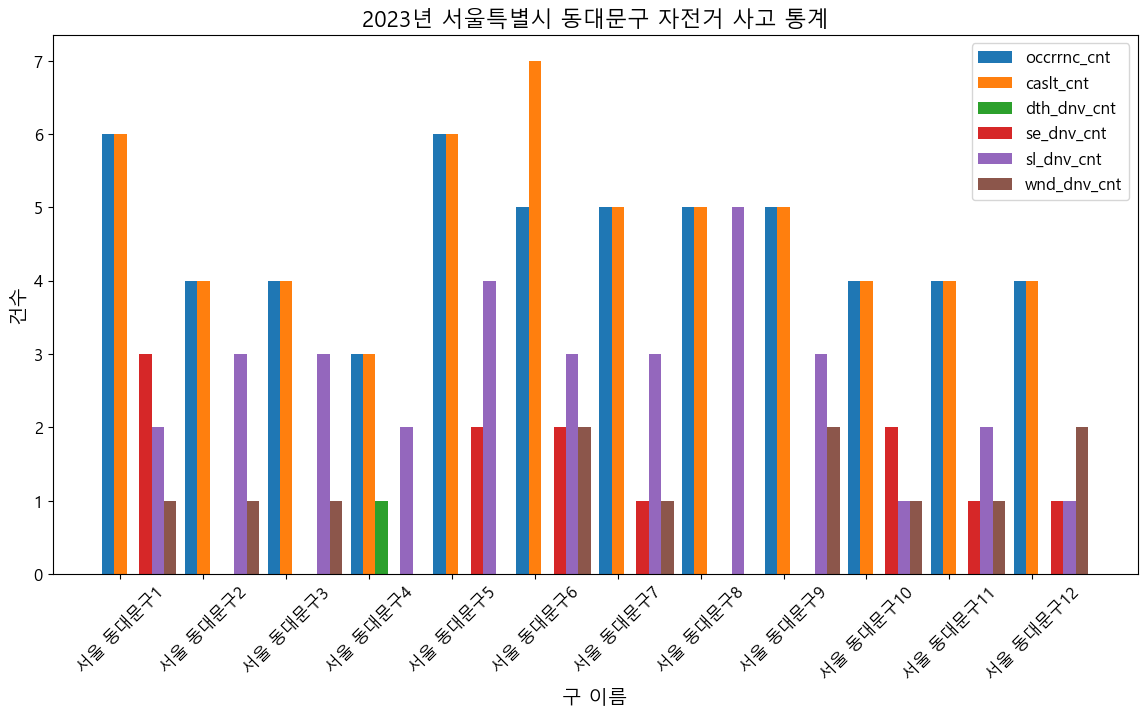

✅ 그래프 저장 완료: bicycle_accidents_chart_2023_서울특별시_동대문구.png
[2025-02-19 17:03:01.731754] URL 요청 성공
✅ JSON 데이터 저장 완료: bicycle_accidents_2023_서울특별시_동작구.json
✅ CSV 데이터 저장 완료: bicycle_accidents_2023_서울특별시_동작구.csv


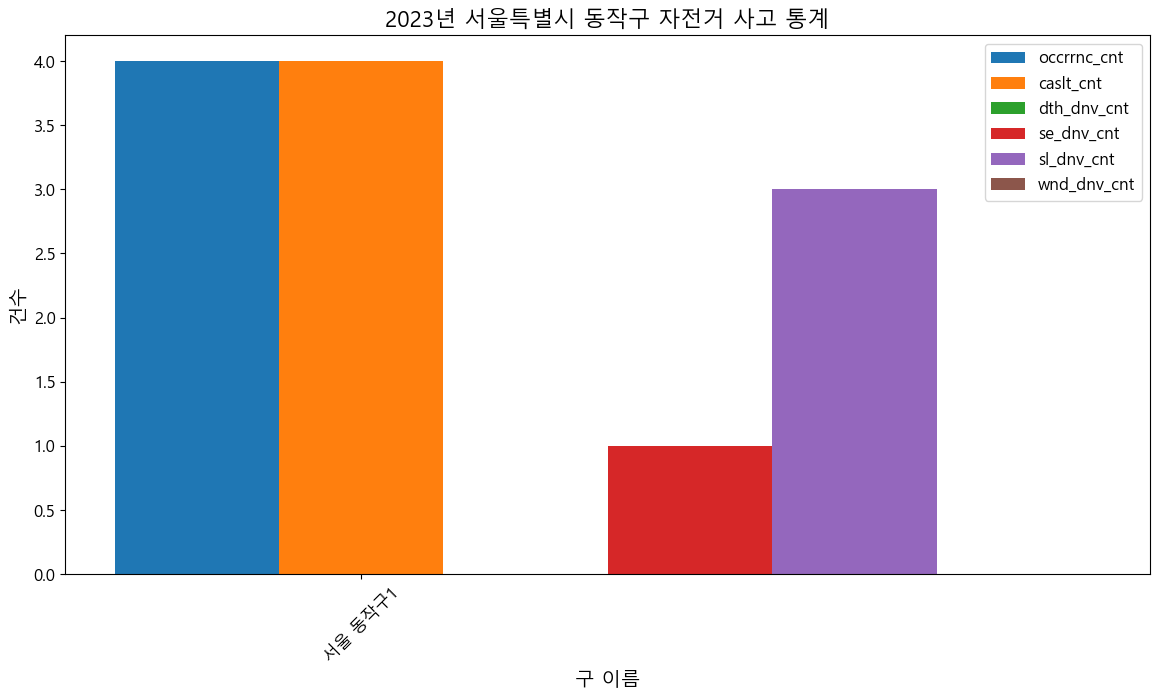

✅ 그래프 저장 완료: bicycle_accidents_chart_2023_서울특별시_동작구.png
[2025-02-19 17:03:02.577601] URL 요청 성공
✅ JSON 데이터 저장 완료: bicycle_accidents_2023_서울특별시_마포구.json
✅ CSV 데이터 저장 완료: bicycle_accidents_2023_서울특별시_마포구.csv


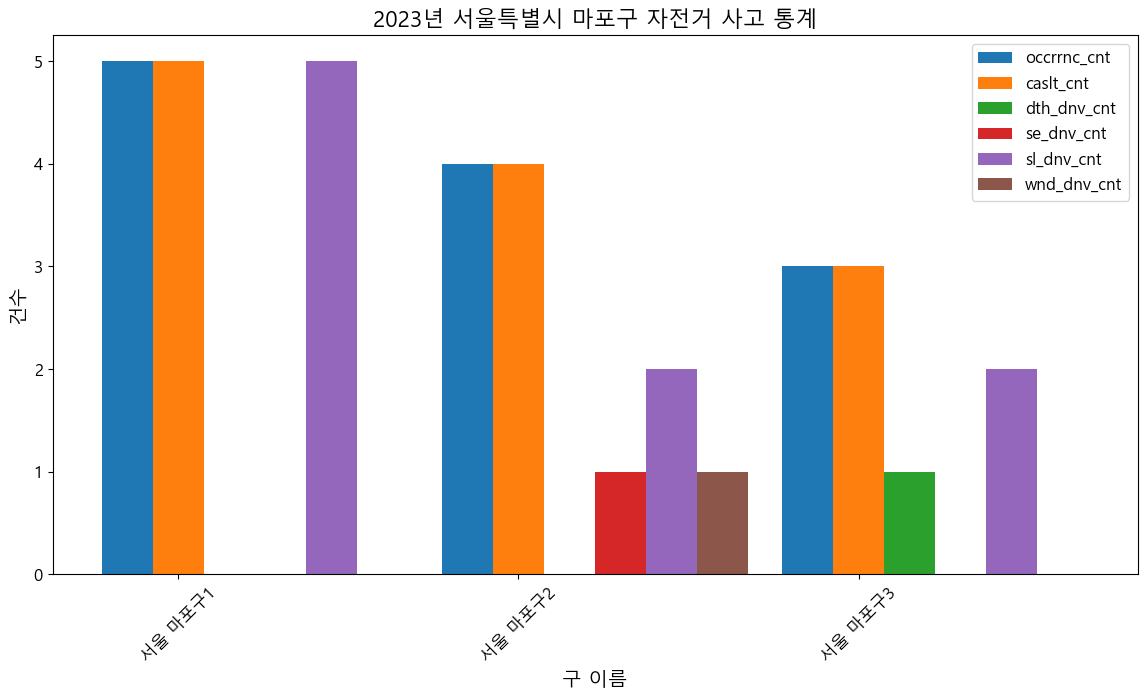

✅ 그래프 저장 완료: bicycle_accidents_chart_2023_서울특별시_마포구.png
[2025-02-19 17:03:03.434173] URL 요청 성공
🚨 [오류] 응답 데이터가 없습니다. 파일을 생성하지 않습니다. (구/군 코드: 410)
[2025-02-19 17:03:03.676634] URL 요청 성공
🚨 [오류] 응답 데이터가 없습니다. 파일을 생성하지 않습니다. (구/군 코드: 650)
[2025-02-19 17:03:03.875218] URL 요청 성공
✅ JSON 데이터 저장 완료: bicycle_accidents_2023_서울특별시_성동구.json
✅ CSV 데이터 저장 완료: bicycle_accidents_2023_서울특별시_성동구.csv


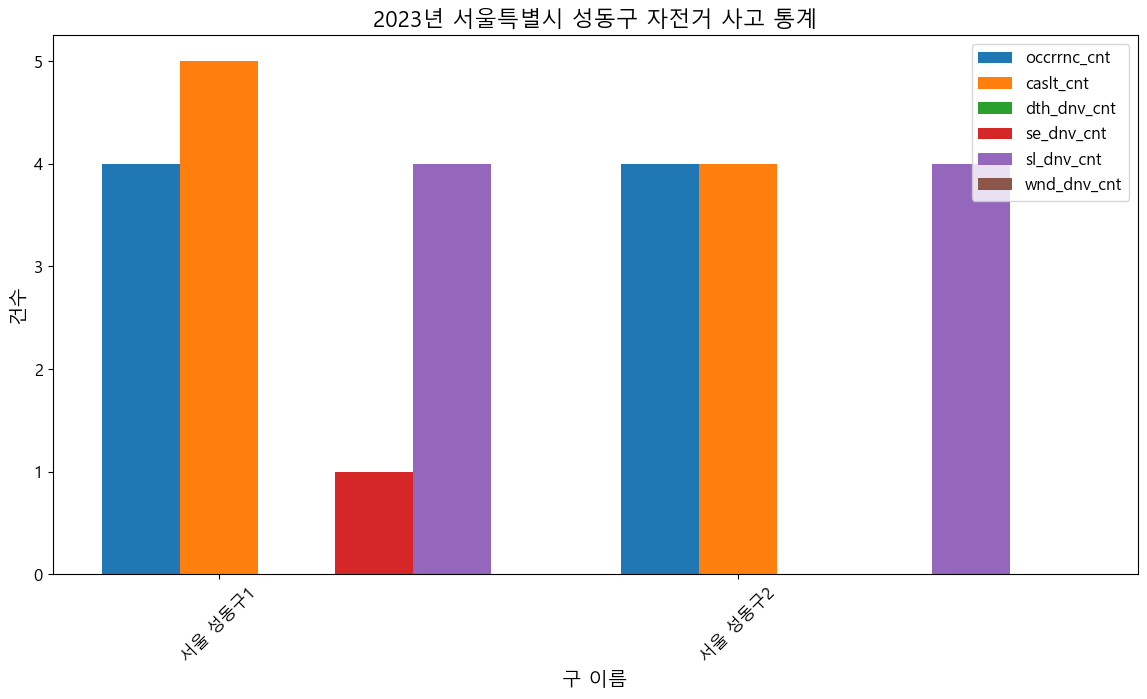

✅ 그래프 저장 완료: bicycle_accidents_chart_2023_서울특별시_성동구.png
[2025-02-19 17:03:04.657971] URL 요청 성공
✅ JSON 데이터 저장 완료: bicycle_accidents_2023_서울특별시_성북구.json
✅ CSV 데이터 저장 완료: bicycle_accidents_2023_서울특별시_성북구.csv


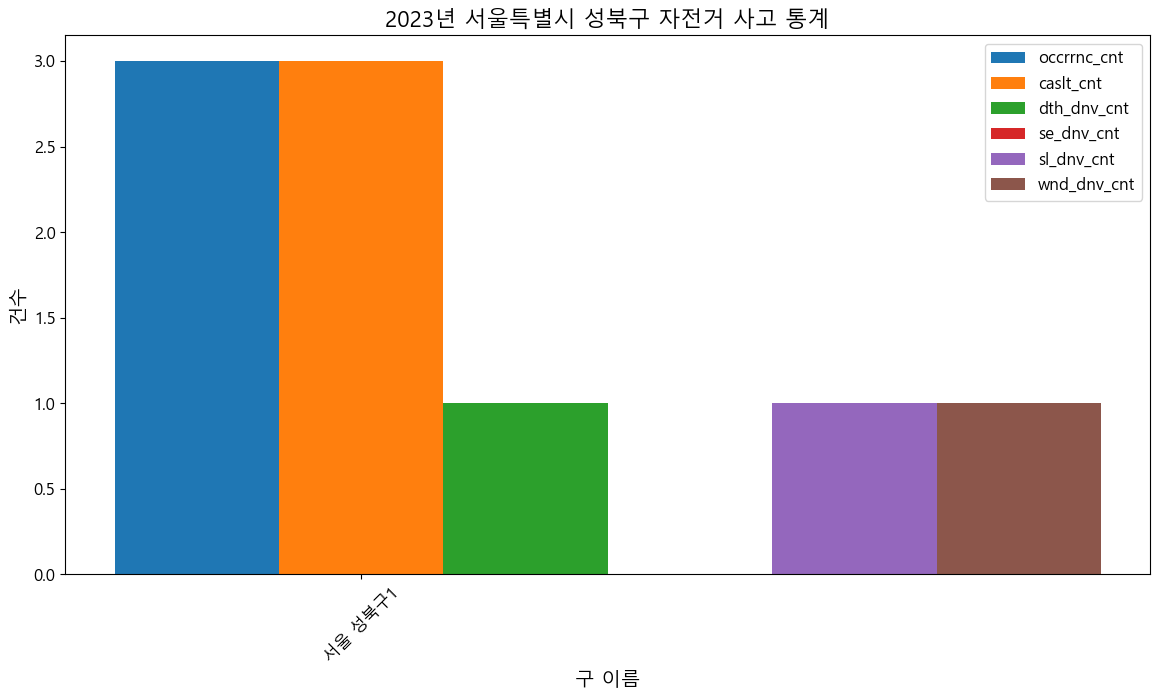

✅ 그래프 저장 완료: bicycle_accidents_chart_2023_서울특별시_성북구.png
[2025-02-19 17:03:05.515576] URL 요청 성공
✅ JSON 데이터 저장 완료: bicycle_accidents_2023_서울특별시_송파구.json
✅ CSV 데이터 저장 완료: bicycle_accidents_2023_서울특별시_송파구.csv


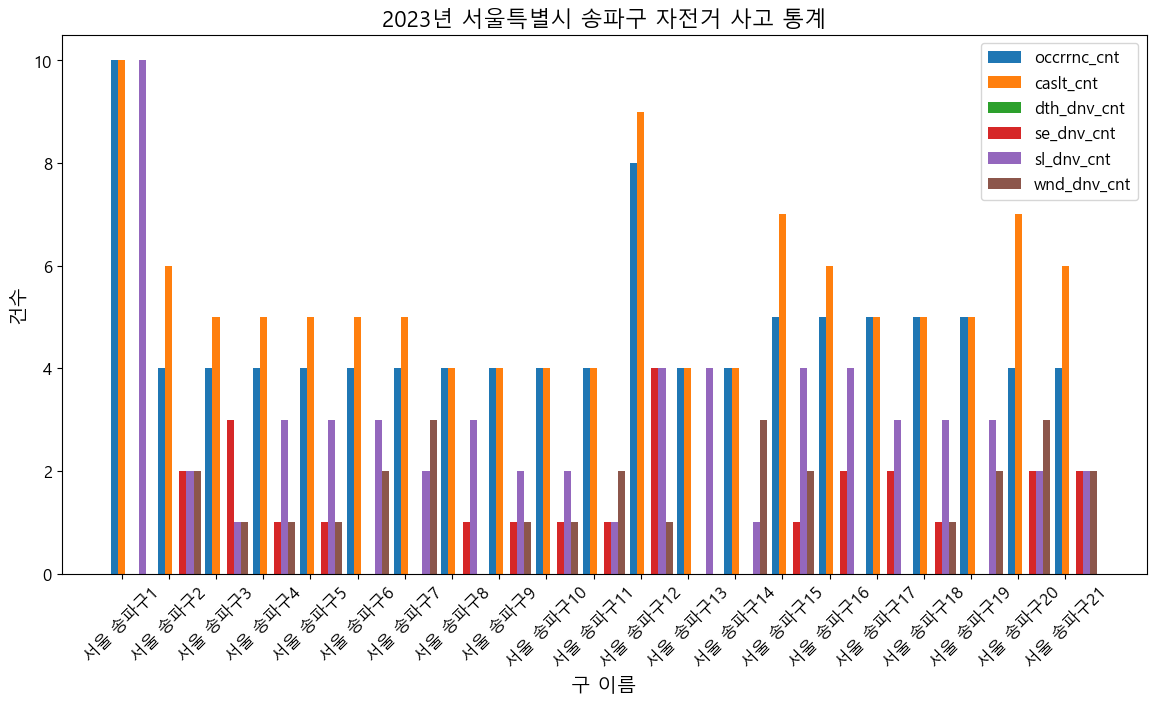

✅ 그래프 저장 완료: bicycle_accidents_chart_2023_서울특별시_송파구.png
[2025-02-19 17:03:06.652235] URL 요청 성공
✅ JSON 데이터 저장 완료: bicycle_accidents_2023_서울특별시_양천구.json
✅ CSV 데이터 저장 완료: bicycle_accidents_2023_서울특별시_양천구.csv


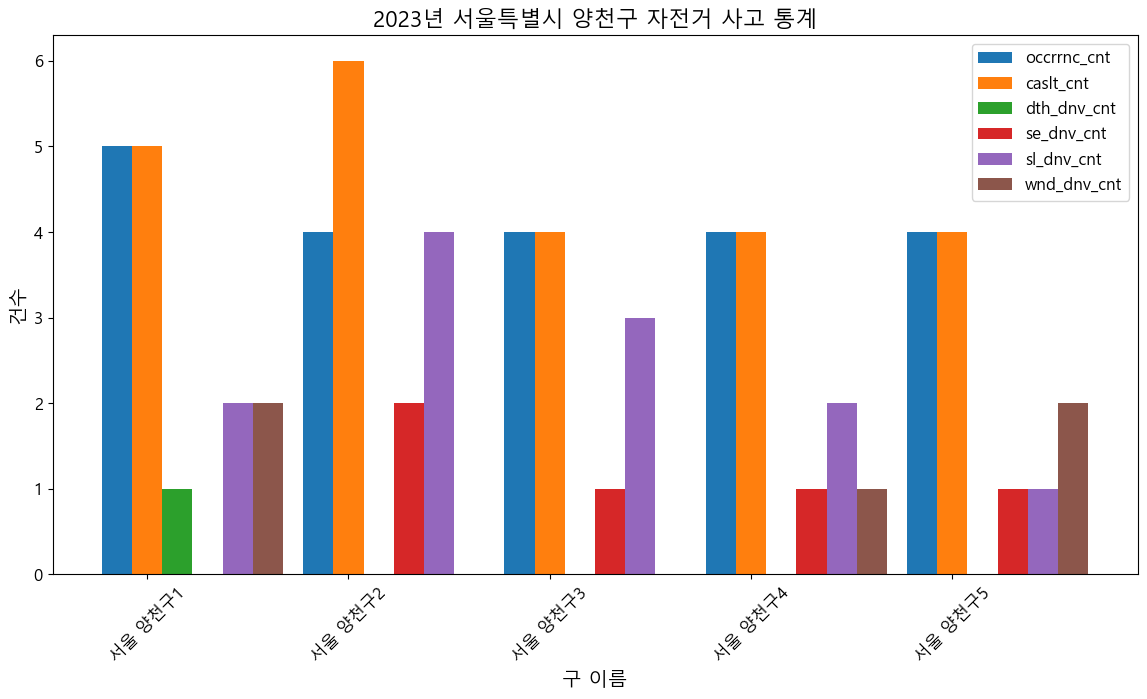

✅ 그래프 저장 완료: bicycle_accidents_chart_2023_서울특별시_양천구.png
[2025-02-19 17:03:07.547092] URL 요청 성공
✅ JSON 데이터 저장 완료: bicycle_accidents_2023_서울특별시_영등포구.json
✅ CSV 데이터 저장 완료: bicycle_accidents_2023_서울특별시_영등포구.csv


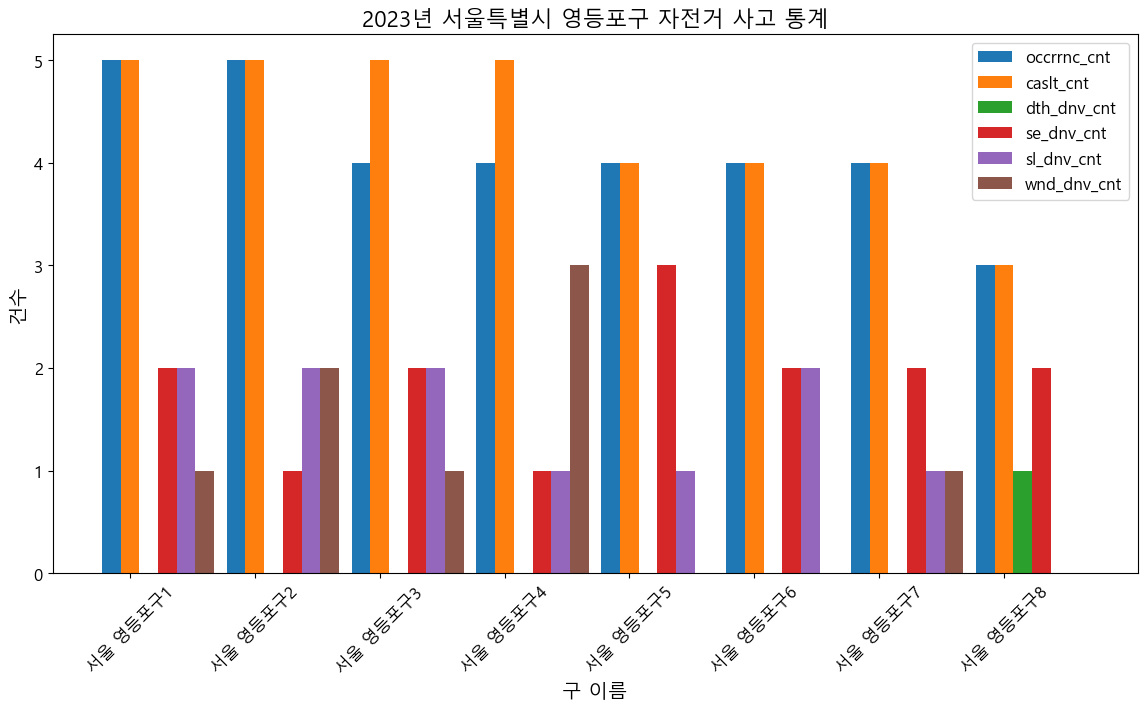

✅ 그래프 저장 완료: bicycle_accidents_chart_2023_서울특별시_영등포구.png
[2025-02-19 17:03:08.452698] URL 요청 성공
✅ JSON 데이터 저장 완료: bicycle_accidents_2023_서울특별시_용산구.json
✅ CSV 데이터 저장 완료: bicycle_accidents_2023_서울특별시_용산구.csv


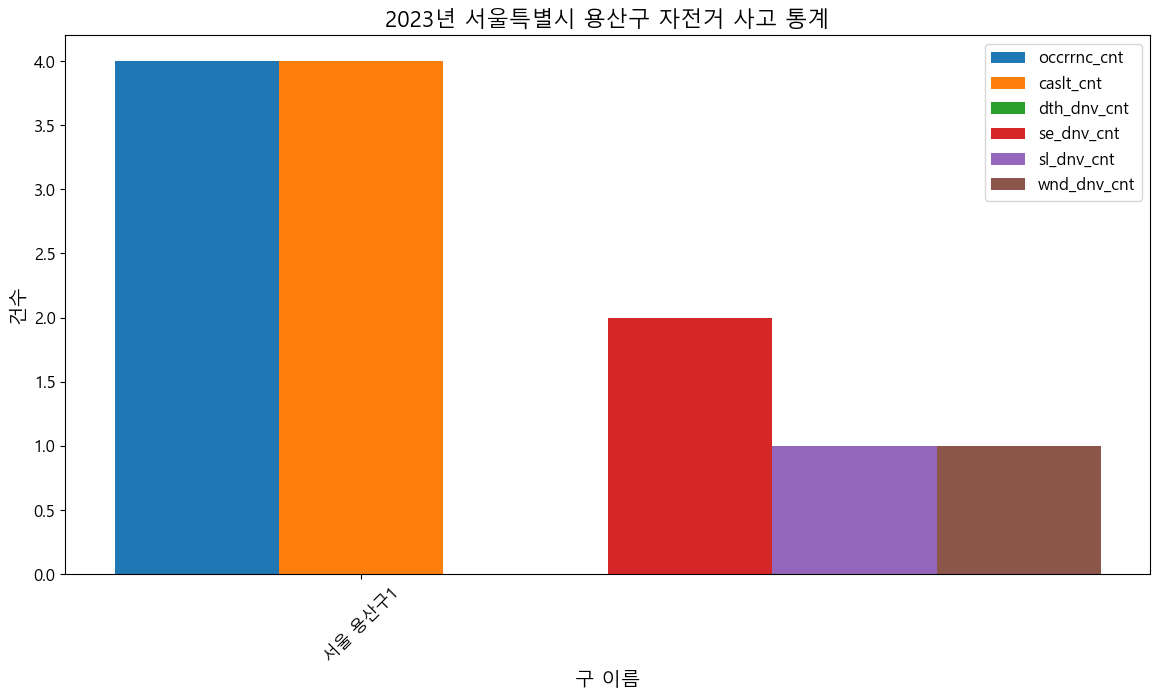

✅ 그래프 저장 완료: bicycle_accidents_chart_2023_서울특별시_용산구.png
[2025-02-19 17:03:09.258488] URL 요청 성공
✅ JSON 데이터 저장 완료: bicycle_accidents_2023_서울특별시_은평구.json
✅ CSV 데이터 저장 완료: bicycle_accidents_2023_서울특별시_은평구.csv


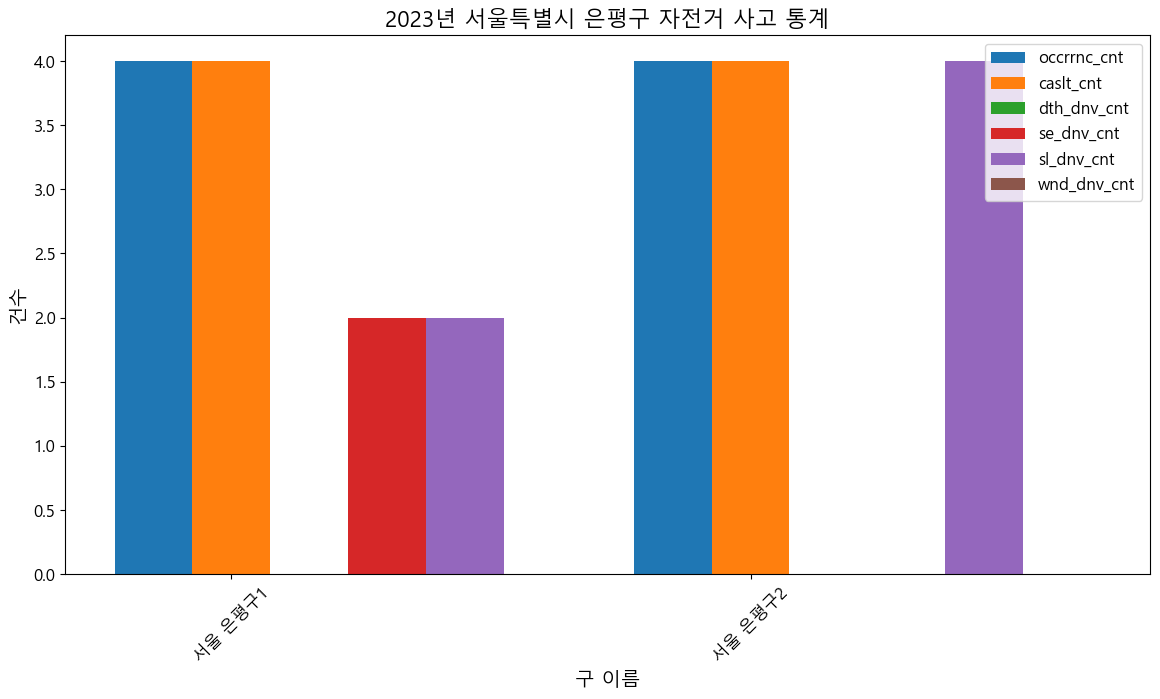

✅ 그래프 저장 완료: bicycle_accidents_chart_2023_서울특별시_은평구.png
[2025-02-19 17:03:10.142077] URL 요청 성공
🚨 [오류] 응답 데이터가 없습니다. 파일을 생성하지 않습니다. (구/군 코드: 110)
[2025-02-19 17:03:10.338357] URL 요청 성공
🚨 [오류] 응답 데이터가 없습니다. 파일을 생성하지 않습니다. (구/군 코드: 140)
[2025-02-19 17:03:10.592578] URL 요청 성공
✅ JSON 데이터 저장 완료: bicycle_accidents_2023_서울특별시_중랑구.json
✅ CSV 데이터 저장 완료: bicycle_accidents_2023_서울특별시_중랑구.csv


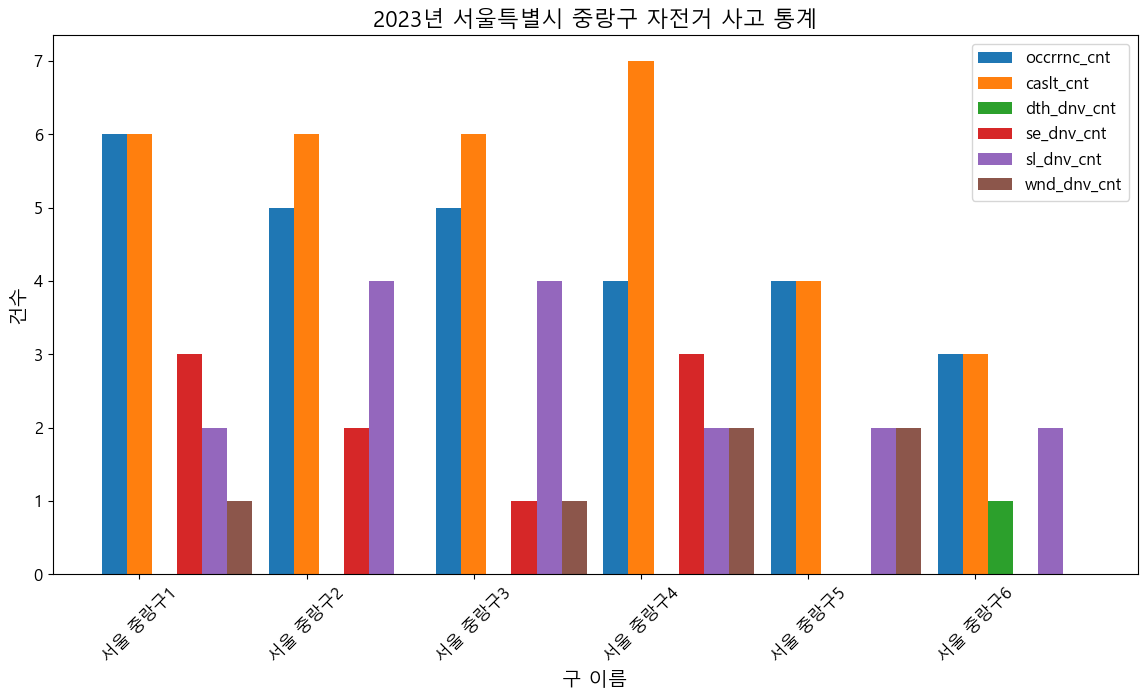

✅ 그래프 저장 완료: bicycle_accidents_chart_2023_서울특별시_중랑구.png


In [14]:
# 실행
if __name__ == "__main__":
    searchYearCd = input("조회할 연도를 입력하세요 (예: 2023): ").strip()
    siDo = "11"  # 서울특별시 고정

    print("\n서울특별시 내 구/군 선택 (9999 입력 시 전체 선택)")
    for district, code in SEOUL_DISTRICTS.items():
        print(f"{district}: {code}", end=" | ")

    guGun = input("\n구/군 코드를 입력하세요 (9999 입력 시 전체 선택): ").strip()

    if guGun == "9999":
        # 전체 구 데이터 요청
        for gu in SEOUL_DISTRICTS.values():
            fetchAndSaveData(searchYearCd, siDo, str(gu))
    else:
        if guGun not in map(str, SEOUL_DISTRICTS.values()):
            print("잘못된 구/군 코드입니다. 프로그램을 종료합니다.")
        else:
            fetchAndSaveData(searchYearCd, siDo, guGun)
